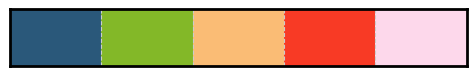

In [1]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from process_data import process_mutation_data

%load_ext autoreload
%autoreload 2

from statistical_test import *
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [43]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
    plt.rcParams['figure.figsize'] = 7, 3
    custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'Zeugma-saved': '#BEBADA', 'EI-all': '#4C72B0', 'Zeugma-all': '#4C72B0', 'BeDivFuzz-all': '#4C72B0'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation_string', hue='algorithm',
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette,
                            width=width, linewidth=1.0, order=x_order, common_norm=True, saturation=1, dodge=True)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)

    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance (%)')
    # tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.pdf'.format(experiment_name, fig_name), bbox_inches='tight', pad_inches=0.1)

In [3]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [4]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index
    # median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [6]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices)
    return stats_df

In [17]:
process_mutation_data("/data/aoli/havoc_eval/havoc-test", [False, True], ["zest", "ei", "bedivfuzz-simple", "bedivfuzz-structure", "zeugma-linked"], 'mutations')
# process_mutation_data("/data/aoli/havoc_eval/havoc-test", [False, True], ["zest", "ei", "bedivfuzz-simple", "bedivfuzz-structure", "zeugma-linked"], 'mutation_byte', "byte_")

/home/vasumv/zeugma/scripts/process_data.py:112: SyntaxWarning: invalid escape sequence '\#'
  axis.set(ylabel = "\# Increased Branch Coverage")


processing ant...
processing maven...
processing rhino...
processing closure...
processing chocopy...
processing gson...
processing jackson...
creating dataframe...


In [18]:
mutation_df = pd.read_pickle("./mutations.pkl")
display(mutation_df)
new_label_names = {
    'zest': 'Zest-all',
    'zest-saved_only': 'Zest-saved',
    'ei': 'EI-all',
    'ei-saved_only': 'EI-saved',
    'zeugma-linked': 'Zeugma-all',
    'zeugma-linked-saved_only': 'Zeugma-saved',
    'bedivfuzz-structure': 'BeDivFuzz-all',
    'bedivfuzz-structure-saved_only': 'BeDivFuzz-saved',
    }
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
mutation_df = mutation_df.dropna()
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
# ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]

,mutation_bytes,mutation_string,algorithm,benchmark_name
0,0.000773,0.005658,zest,ant
1,0.381250,0.734328,zest,ant
2,0.581818,0.415663,zest,ant
3,0.038462,0.083333,zest,ant
4,0.027624,0.311475,zest,ant
...,...,...,...,...
1914420,0.006377,0.040745,zeugma-linked-saved_only,jackson
1914421,0.000000,0.000000,zeugma-linked-saved_only,jackson
1914422,0.034682,0.030928,zeugma-linked-saved_only,jackson
1914423,0.004972,0.014732,zeugma-linked-saved_only,jackson


In [19]:
non_zero_mutation_df = mutation_df[mutation_df['mutation_string'] != 0]
non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


/tmp/ipykernel_1693251/1957240628.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
/tmp/ipykernel_1693251/1957240628.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


# Mutation Distance (Byte vs String)

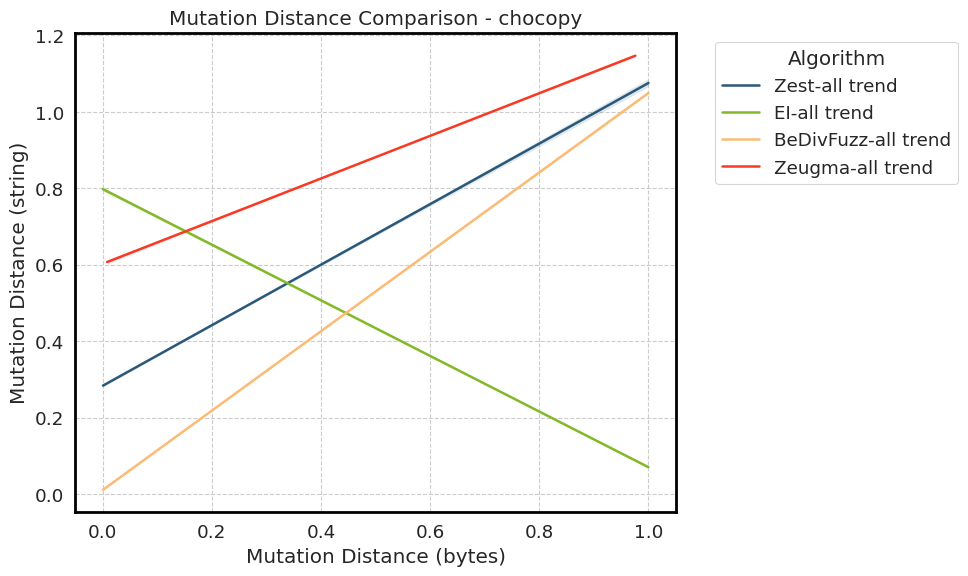

In [41]:

def plot_mut_distance_scatter(df, benchmark_name):
    """
    Create a scatter plot of mutation distances with trend lines for each algorithm.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing mutation data with columns:
        - mutation_bytes
        - mutation_string
        - algorithm
        - benchmark_name
    benchmark_name (str): Name of the benchmark to plot
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    # Filter data for the specified benchmark
    plot_data = df[df['benchmark_name'] == benchmark_name].copy()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Add trend lines for each algorithm
    for algo in plot_data['algorithm'].unique():
        algo_data = plot_data[plot_data['algorithm'] == algo]
        sns.regplot(
            data=algo_data,
            x='mutation_bytes',
            y='mutation_string',
            scatter=False,
            scatter_kws={'s': 1},
            ci=99,
            label=f'{algo} trend'
        )
    
    # Customize the plot
    plt.title(f'Mutation Distance Comparison - {benchmark_name}')
    plt.xlabel('Mutation Distance (bytes)')
    plt.ylabel('Mutation Distance (string)')
    
    # Adjust legend
    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

fig = plot_mut_distance_scatter(non_zero_all_input_df, "chocopy")
plt.show()

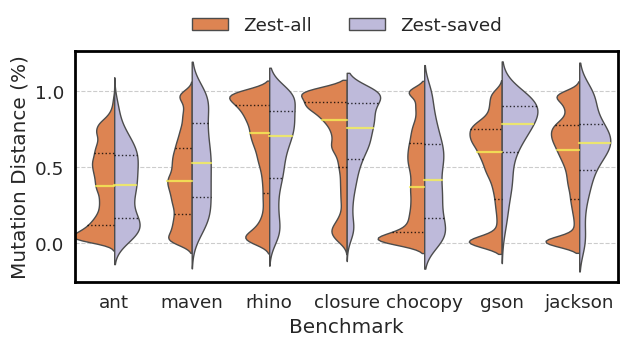

In [44]:
violin_plot_for_mutation_distance(non_zero_zest_df, "t1", 'rq1_wo_zero_mutations', width=1.2)

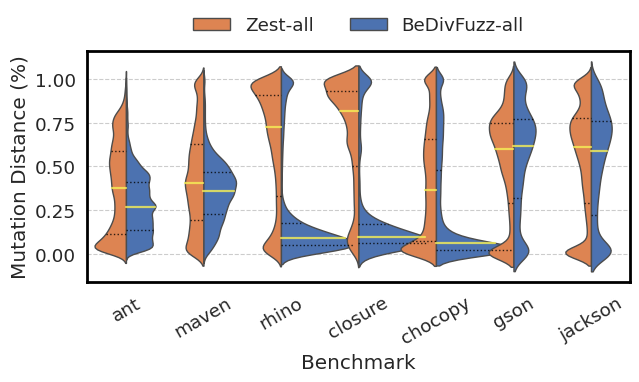

In [45]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'chocopy', 'gson', 'jackson')
zest_versus_bedivfuzz = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|BeDivFuzz')]
violin_plot_for_mutation_distance(zest_versus_bedivfuzz, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

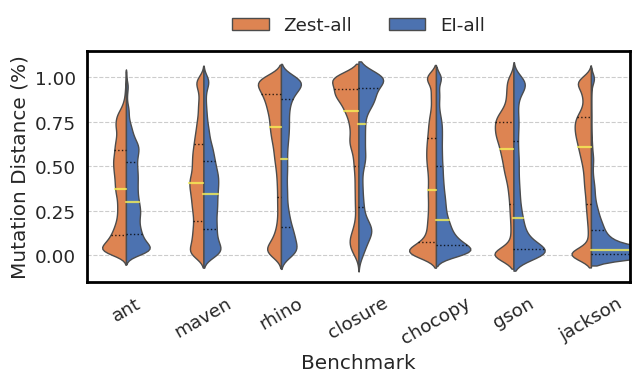

In [46]:
zest_versus_ei = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|EI')]
violin_plot_for_mutation_distance(zest_versus_ei, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

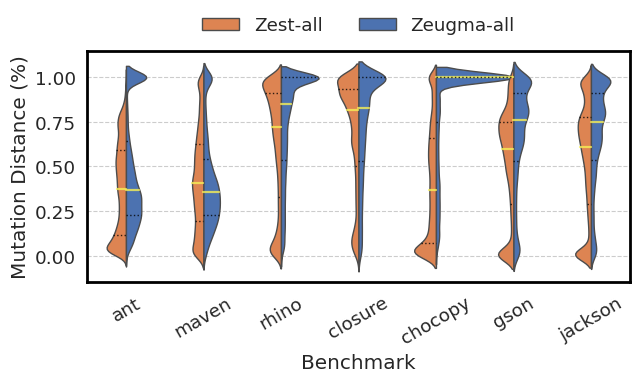

In [47]:
zest_versus_zeugma = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|Zeugma')]
violin_plot_for_mutation_distance(zest_versus_zeugma, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

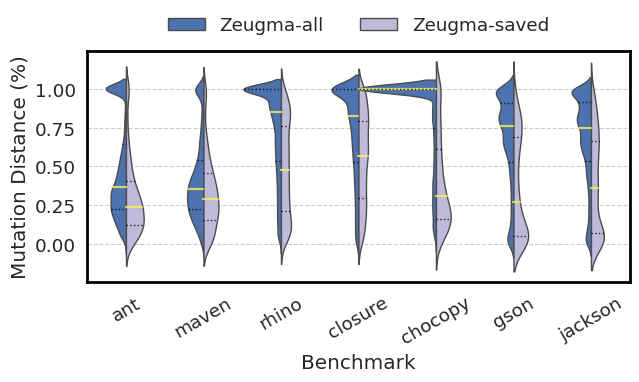

In [48]:
non_zero_zeugma_df = non_zero_mutation_df[non_zero_mutation_df['algorithm'].str.contains('Zeugma')]
violin_plot_for_mutation_distance(non_zero_zeugma_df, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)